Usando o exemplo 499

In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from lime import lime_text
from sklearn.pipeline import make_pipeline
from tensorflow.keras import backend as K  # Importar backend do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('../FakeNewsNet.csv')

In [4]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [5]:
df.shape

(23196, 5)

<Axes: xlabel='real', ylabel='count'>

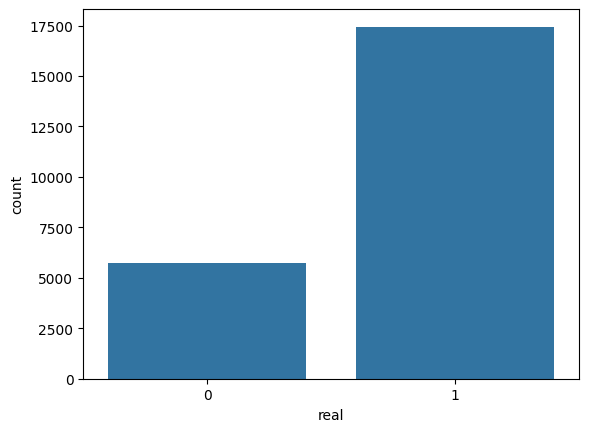

In [6]:
sns.countplot(x='real', data = df)

**Pré-Processamento**

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["title"].apply(preprocess_text)

In [10]:
df.head(5)

,title,news_url,source_domain,tweet_num,real,clean_text
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,kandi burruss explodes rape accusation real ho...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,people choice award best red carpet look
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,sophia bush sends sweet birthday message one t...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,colombian singer maluma spark rumour inappropr...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1,gossip girl year later upper east siders shock...


<Axes: xlabel='real', ylabel='count'>

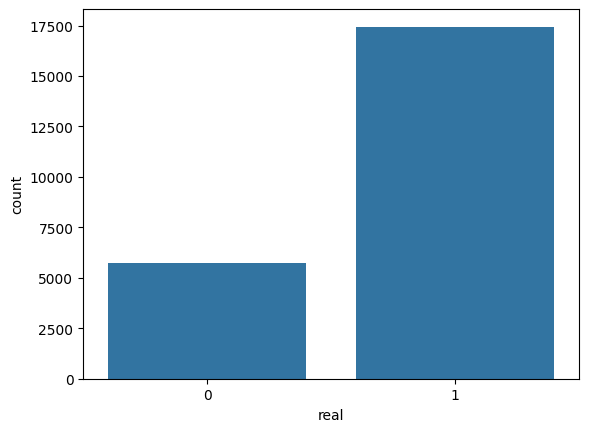

In [11]:
sns.countplot(x="real", data=df) # validando se mudou as classes

In [12]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['real'])

In [13]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [14]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [16]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [18]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


522/522 ━━━━━━━━━━━━━━━━━━━━ 261s 475ms/step - accuracy: 0.7850 - loss: 0.4937 - val_accuracy: 0.8244 - val_loss: 0.4248
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 256s 461ms/step - accuracy: 0.8504 - loss: 0.3597 - val_accuracy: 0.8362 - val_loss: 0.3857
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 267s 469ms/step - accuracy: 0.8756 - loss: 0.3055 - val_accuracy: 0.8405 - val_loss: 0.3933
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 297s 534ms/step - accuracy: 0.8919 - loss: 0.2648 - val_accuracy: 0.8341 - val_loss: 0.4001
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 323s 534ms/step - accuracy: 0.9087 - loss: 0.2270 - val_accuracy: 0.8292 - val_loss: 0.4359
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 321s 530ms/step - accuracy: 0.9206 - loss: 0.1972 - val_accuracy: 0.8351 - val_loss: 0.4726
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 326s 534ms/step - accuracy: 0.9338 - loss: 0.1672 - val_accuracy: 0.8319 - val_loss: 0.5757
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 307s 504ms/step - accuracy: 0.9451 - loss: 0.14

**Métricas**

In [19]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      1131
           1       0.87      0.87      0.87      3509

    accuracy                           0.81      4640
   macro avg       0.74      0.74      0.74      4640
weighted avg       0.81      0.81      0.81      4640



In [20]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.8063
Precisão: 0.8078
Recall: 0.8063
F1-Score: 0.8070


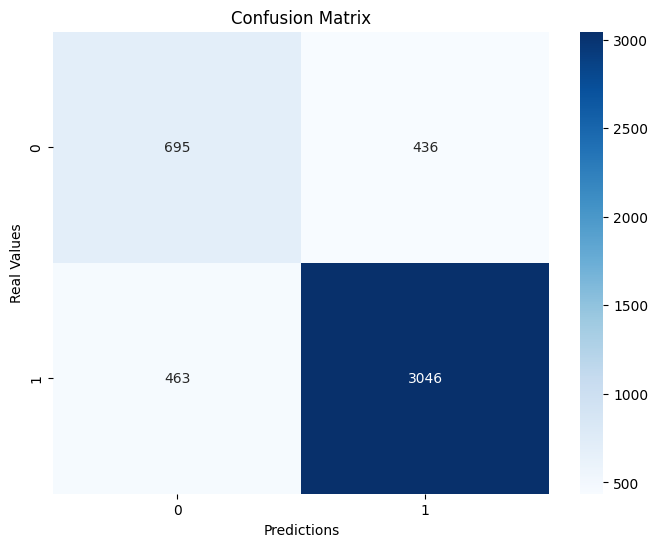

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [22]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Número da linha no X_test: 499
Original text:
style tip dressing like princess eleanor royal
Classe real: 1
Classe predita: 1
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step
[(np.str_('eleanor'), 0.13163009189170458), (np.str_('princess'), 0.030594561453246488), (np.str_('like'), 0.016808467151954134), (np.str_('tip'), -0.01660022639684502), (np.str_('style'), 0.015780367359786846), (np.str_('royal'), 0.011478215200831763), (np.str_('dressing'), 0.008456027501213296)]


In [23]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
eleanor: 0.1316
princess: 0.0306
like: 0.0168
tip: -0.0166
style: 0.0158
royal: 0.0115
dressing: 0.0085


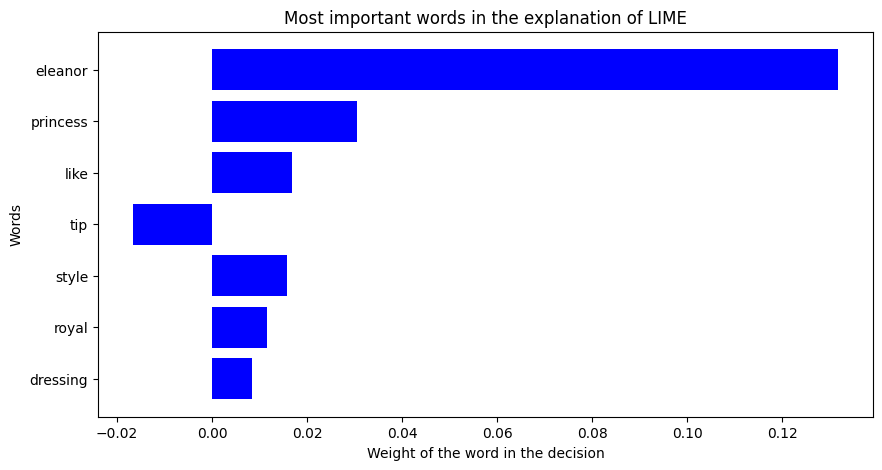

In [24]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [25]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

eleanor: 0.13163009189170458
princess: 0.030594561453246488
like: 0.016808467151954134
tip: -0.01660022639684502
style: 0.015780367359786846
royal: 0.011478215200831763
dressing: 0.008456027501213296


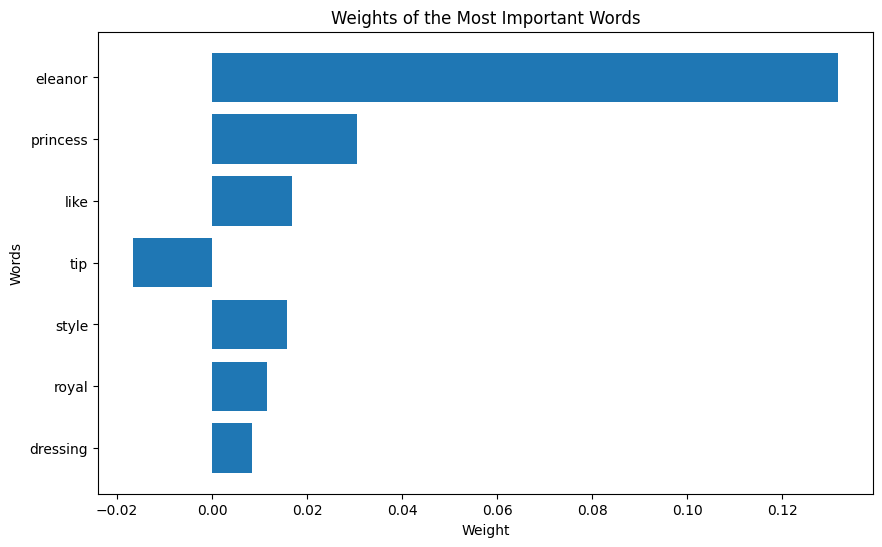

In [26]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [27]:
le.classes_

array([0, 1])

Palavras do exemplo e seus pesos de atenção na decisão do LSTM:
  Feature    Weight
6   <OOV>  0.999936
5  square  0.500890
4   <OOV>  0.180260
3    park  0.033070
2   <OOV>  0.031606
0   <OOV>  0.009399
1   <OOV>  0.000000


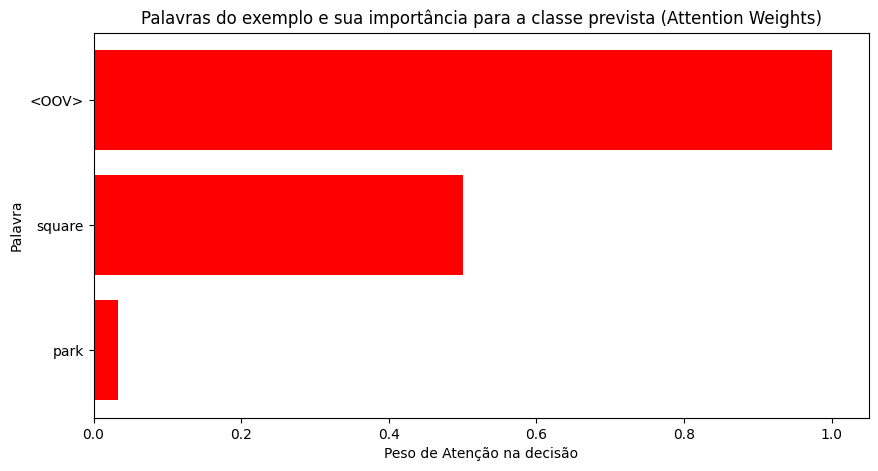

In [36]:
from tensorflow.keras.models import Model
import tensorflow as tf

# ========= 1. "Feature names" → tokens do texto (equivalente ao CountVectorizer) =========
seq = tokenizer.texts_to_sequences([sample_text])
seq_pad = pad_sequences(seq, maxlen=max_len, padding="post")

# Tokens reais do exemplo (equivalente a vect.build_analyzer())
tokens = tokenizer.sequences_to_texts(seq)[0].split()

# ========= 2. "Coeficientes" → extrair pesos de atenção =========
# Usar Model API para criar modelos intermediários
try:
    # Tentar com inputs[0]
    lstm_model = Model(
        inputs=model.inputs[0],
        outputs=model.layers[1].output  # LSTM output
    )
    lstm_output = lstm_model.predict(seq_pad, verbose=0)
except:
    # Fallback: fazer previsão direta e extrair via função customizada
    # Criar uma função que retorna a saída do LSTM
    lstm_layer = model.layers[1]
    
    # Usar a previsão normal e extrair via submodelo
    def get_lstm_output(x):
        embedding = model.layers[0](x)
        lstm_out = model.layers[1](embedding)
        return lstm_out
    
    lstm_output = get_lstm_output(seq_pad).numpy()

# Extrair pesos da camada de atenção
attention_layer = model.layers[2]  # AttentionLayer está no índice 2

# Obter os pesos treinados
W = attention_layer.W.numpy()
b = attention_layer.b.numpy()

# Calcular pesos de atenção manualmente usando a fórmula da camada AttentionLayer
# et = tanh(x @ W + b), at = softmax(et)
et = np.squeeze(np.tanh(np.dot(lstm_output[0], W) + b), axis=-1)
at = np.exp(et - np.max(et)) / np.sum(np.exp(et - np.max(et)), axis=0)  # softmax

# Remover padding: pegar apenas os pesos das sequências reais
num_real_tokens = len(tokens)
pesos_atencao = at[-num_real_tokens:].flatten()[:num_real_tokens]

# Normalizar os pesos para comparabilidade com SVM
pesos_atencao = (pesos_atencao - pesos_atencao.min()) / (pesos_atencao.max() - pesos_atencao.min() + 1e-8)

# ========= 3. Criar DataFrame (equivalente ao SVM) =========
importancias = pd.DataFrame({
    "Feature": tokens,
    "Weight": pesos_atencao
})

# ========= 4. Marcar palavras do exemplo (todas são do exemplo no LSTM) =========
importancias["No_Exemplo"] = True

# ========= 5. Ordenar por importância =========
importancias_exemplo = importancias.sort_values(
    by="Weight",
    ascending=False
)

print("Palavras do exemplo e seus pesos de atenção na decisão do LSTM:")
print(importancias_exemplo[["Feature", "Weight"]])

# ========= 6. Plotar (mesmo estilo do SVM) =========
plt.figure(figsize=(10, 5))
plt.barh(
    importancias_exemplo["Feature"],
    importancias_exemplo["Weight"],
    color="red"
)
plt.xlabel("Peso de Atenção na decisão")
plt.ylabel("Palavra")
plt.title("Palavras do exemplo e sua importância para a classe prevista (Attention Weights)")
plt.gca().invert_yaxis()
plt.show()
